In [ ]:
!pip install stellargraph[demos]

In [ ]:
!pip install networkx

In [ ]:
#!export PYTHONPATH=$PYTHONPATH:~/.local/lib/python3.7/site-packages

In [131]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random
from tqdm import tqdm

pd.set_option('display.max_columns', 500)
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler
from sklearn.model_selection import train_test_split

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score

from stellargraph import globalvar

from stellargraph import datasets
from IPython.display import display, HTML

## DATASET PROCESING

Загружаем граф:

In [3]:
graph = pd.read_csv("duo_edge.csv")

In [4]:
graph.dropna(inplace=True)

In [5]:
graph['adjacent'] = graph['adjacent'].astype("str")

In [6]:
graph.head() # помогите меня держут в рабстве, мне не платят деньги и не дают еду. я хочу домой...

,adjacent
0,"157949, 180518"
1,0
2,"1, 120552, 120553"
3,"2, 199677"
4,"3, 145089"


Генерируем edge list:

In [8]:
def get_index_tuples(df):
    lst = []
    for i in tqdm(range(len(df))):
        tmp = df['adjacent'].iloc[i].split(',')
        for edge in tmp:
            lst.append([i, int(edge)])
            
    return lst
lst = get_index_tuples(graph)
lst = pd.DataFrame(lst)
lst

100%|██████████| 206438/206438 [00:01<00:00, 106738.64it/s]


,0,1
0,0,157949
1,0,180518
2,1,0
3,2,1
4,2,120552
...,...,...
352068,206434,210382
352069,206435,210383
352070,206436,210385
352071,206437,112090


In [10]:
edge_data = pd.DataFrame(
    {
        "source": list(lst[0]),
        "target": list(lst[1])
    }
)
edge_data

,source,target
0,0,157949
1,0,180518
2,1,0
3,2,1
4,2,120552
...,...,...
352068,206434,210382
352069,206435,210383
352070,206436,210385
352071,206437,112090


Дропаем лишнее (структурное описание/копии индекса/артефакты): 

In [14]:
node_data = pd.read_csv('node_data.csv')

In [6]:
node_data = graph.drop(["edge_id", "adjacent", "Unnamed: 0", "style_<pandas.io.formats.style.Styler object at 0x000001BA9BC98AC0>"], axis = 1)

Создаем граф:

In [7]:
G = sg.StellarGraph(
    {"street": node_data}, {"connection": edge_data}
)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 231688, Edges: 1149492

 Node types:
  street: [231688]
    Features: float32 vector, length 100
    Edge types: street-connection->street

 Edge types:
    street-connection->street: [1149492]
        Weights: all 1 (default)
        Features: none


## CONCATENATE EMBEDDINGS

Загружаем файл с путями:

In [15]:
node_data.head()

,Unnamed: 0,edge_id,id1,id2,dist,lanes,lat,lon,bridleway,construction,corridor,cycleway,elevator,footway,living_street,path,pedestrian,primary,primary_link,proposed,residential,secondary,secondary_link,service,steps,street_lamp,tertiary,tertiary_link,track,unclassified,artificial_turf,asphalt,cobblestone,compacted,concrete,concrete:plates,dirt,fine_gravel,granite,grass,grass_paver,gravel,gravel_turf,ground,marble,metal,paved,paving_stones,pebblestone,rubber,sand,sett,tartan,unhewn_cobblestone,unpaved,wood,automatic,half,no,yes
0,0,0,253123732,6270330562,42.735180,2,55.766340,37.615257,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,1,6270330562,3787556792,8.834186,2,55.766140,37.615465,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,2,3787556792,96484784,13.060046,2,55.766055,37.615552,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,3,3,96484784,4763136342,4.216574,2,55.765987,37.615620,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,4,4,4763136342,4675485825,9.997910,2,55.765930,37.615672,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [16]:
cors = []
for i in tqdm(range(len(node_data))):
    cors.append([node_data.lat.iloc[i], node_data.lon.iloc[i]])

100%|██████████| 210392/210392 [00:04<00:00, 50217.25it/s]


In [17]:
cors[:10]

[[55.766340150000005, 37.61525655],
 [55.766139800000005, 37.6154646],
 [55.76605455, 37.61555235],
 [55.76598675, 37.61561985],
 [55.76592995, 37.6156721],
 [55.7657995, 37.61578565],
 [55.76558495, 37.6159636],
 [55.765424800000005, 37.61609335],
 [55.76521935, 37.6162538],
 [55.76504065, 37.6163931]]

In [73]:
import numpy as np
from sklearn.neighbors import BallTree, DistanceMetric

X = np.array([[np.radians(x) for x in list_] for list_ in cors])
tree = BallTree(X, leaf_size=3, metric = DistanceMetric.get_metric('haversine'))             

dist, idx = tree.query([cors[0]], k = 1)

In [55]:
c = 2 * asin(sqrt(a)) 
r = 6371

ValueError: math domain error

In [102]:
node_data.lat.iloc[178405], node_data.lon.iloc[178405]

(55.7662884, 37.63236235)

In [115]:
for i in tqdm(range(len(samples))):
    edges_id=[]
    ok = True
    if i not in ids_to_remove:
        for cor in samples[i]['cors']:
            dist, idx = tree.query([[cor[0]* np.pi / 180, cor[1]* np.pi / 180]], k = 1)
            if dist*6371000 > 100:
                ids_to_remove.append(i)
                ok = False
                break
            edges_id.append(idx[0][0])
        if ok:
            samples[i]['edges'] = edges_id

100%|██████████| 22503/22503 [06:20<00:00, 59.20it/s] 


In [106]:
len(ids_to_remove), len(samples)

(12094, 22503)

In [116]:
ids_to_remove = list(set(ids_to_remove))

In [117]:
samples_copy = samples.copy()

In [118]:
for i in ids_to_remove[::-1]:
    samples_copy.pop(i)

In [120]:
for samp in samples_copy:
    del samp['cors']

In [121]:
samples_copy[5]

{'id': 33,
 'time': 4277,
 'mean_wheel': 8.204606525911714,
 'edges': [195276,
  195276,
  195276,
  195276,
  195276,
  195281,
  195281,
  195281,
  195281,
  195281,
  195281,
  195281,
  195281,
  195281,
  195281,
  195281,
  195281,
  195281,
  195281,
  195181,
  195276,
  195276,
  195277,
  195277,
  195277,
  195276,
  195277,
  195276,
  195276,
  195276,
  195276,
  195181,
  195181,
  195179,
  195185,
  195183,
  131548,
  131550,
  131550,
  206503,
  137790,
  206503,
  206503,
  131548,
  131548,
  131548,
  131548,
  131548,
  203073,
  203073,
  203073,
  203073,
  206505,
  206505,
  206505,
  206505,
  206505,
  206505,
  206506,
  19686,
  19686,
  53363,
  53362,
  53362,
  53364,
  53364,
  52561,
  52561,
  52561,
  101619,
  101619,
  101619,
  52739,
  52559,
  52545,
  206515,
  206515,
  206515,
  132476,
  132476,
  195258,
  132476,
  132476,
  132476,
  206513,
  206513,
  206513,
  206513,
  206513,
  132476,
  206510,
  206510,
  132476,
  206513,
  20

In [114]:
import pickle
with open('samples.pkl', 'rb') as f:
    samples = pickle.load(f)

In [11]:
routes = pd.read_csv("dgi_sage_128_5_relu_1100e_0.33l.csv", index_col = 0)

In [13]:
routes.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,-0.002338,-0.213843,0.010137,-0.028450,0.006746,0.047177,0.076987,-0.034726,-0.013607,-0.008969,0.005453,0.042764,-0.127570,-0.060813,-0.205069,0.006187,-0.006967,0.042522,-0.029246,0.007081,0.013705,0.047252,-0.088825,-0.033271,-0.159286,-0.034756,-0.036575,-0.013160,0.051381,0.007805,0.020794,-0.074186,-0.027249,0.013245,-0.076959,-0.212199,0.022312,0.051649,0.004775,0.023525,-0.005682,0.026609,-0.027189,-0.047381,0.053455,0.011248,0.023457,-0.053407,0.020209,0.019984,0.018017,0.056980,0.039344,-0.023295,0.025407,0.031761,-0.024471,-0.045821,0.031825,0.017782,-0.212559,-0.047726,0.020870,-0.182602,-0.015188,-0.066406,-0.149556,-0.002781,-0.016304,-0.011725,0.003075,-0.033008,0.007626,0.221079,0.063359,-0.105694,-0.002307,0.020209,-0.015000,0.002496,-0.001665,-0.151854,0.111323,-0.000734,0.115533,0.067222,-0.157441,-0.015518,-0.029022,0.136532,-0.189865,0.015947,0.213632,0.005989,0.135832,-0.121423,0.023816,-0.007506,-0.096931,0.136270,0.061279,-0.160116,-0.009681,-0.184406,0.019373,-0.032020,0.124012,0.104287,-0.192470,-0.004725,0.150739,0.028325,-0.198222,-0.041471,0.002549,0.015390,0.022949,-0.150990,-0.032659,-0.010351,-0.153055,-0.144263,-0.058743,-0.154583,-0.035537,-0.177358,-0.114154,0.006289
1,-0.003499,-0.207329,0.006055,-0.007346,0.002577,0.042753,0.073339,-0.037056,-0.009329,-0.018686,0.007166,0.038535,-0.150218,-0.080195,0.002144,0.001304,-0.003476,0.044390,-0.026687,0.006439,0.010862,0.036583,-0.088889,0.005187,-0.153108,-0.043226,-0.048377,-0.010481,0.048558,0.017388,0.016874,-0.109154,-0.035043,0.012821,-0.073077,-0.188261,0.014724,0.045937,0.001210,0.025085,-0.006406,0.024499,-0.023423,-0.057262,0.043050,0.009770,0.023382,-0.052388,0.016205,0.017178,0.015706,0.053915,0.038669,-0.027466,0.017329,0.032088,-0.047288,-0.056313,0.031600,0.014485,-0.197122,-0.049497,0.021712,-0.111827,-0.004847,-0.047638,-0.172800,-0.034637,-0.041619,-0.006857,0.043450,-0.016459,-0.058341,0.257945,-0.046461,-0.032303,0.010646,0.080387,-0.027186,0.007776,-0.030417,-0.175917,0.092988,0.023777,-0.050263,0.045994,-0.155623,-0.022524,-0.006367,-0.135150,-0.167197,0.034512,0.187004,-0.016804,-0.114511,-0.150771,0.028479,-0.017613,-0.071755,0.123514,0.137740,-0.180717,-0.017545,-0.193212,0.022681,-0.015965,0.151612,0.156371,-0.200182,0.013346,0.177793,-0.037692,-0.195612,-0.001913,0.000598,0.006433,0.075959,-0.041263,-0.012866,0.000214,0.066708,-0.210799,-0.085771,-0.195067,0.017457,-0.208052,0.099082,0.082680
2,-0.004116,-0.257037,0.008042,-0.012346,0.003790,0.053099,0.090492,-0.045096,-0.012093,-0.021482,0.008530,0.047897,-0.181337,-0.095616,-0.082423,0.002337,-0.004794,0.054157,-0.033116,0.007993,0.013750,0.046476,-0.109003,0.002316,-0.188719,-0.051763,-0.057607,-0.013260,0.059976,0.019878,0.021286,-0.129289,-0.041825,0.015788,-0.090210,-0.239028,0.019203,0.057199,0.002022,0.030528,-0.007747,0.030363,-0.029298,-0.068780,0.054367,0.012205,0.028687,-0.064401,0.020478,0.021490,0.019610,0.066583,0.047524,-0.033061,0.022471,0.039303,-0.054751,-0.067529,0.038787,0.018261,-0.246485,-0.060437,0.026500,-0.153853,0.001230,0.010162,-0.166314,0.021652,-0.001797,-0.001391,0.038082,0.033703,0.009489,0.223447,-0.058192,0.005109,0.001417,0.073571,-0.002714,0.014159,-0.003936,-0.170199,0.066632,-0.027732,0.027306,0.031361,-0.106613,0.000299,0.041450,0.040789,-0.143480,0.034144,0.202909,-0.049842,0.034879,-0.134209,0.103965,-0.006506,-0.032863,0.090741,0.071705,-0.169929,-0.004984,-0.203166,0.025326,0.034486,0.144112,0.050968,-0.216601,0.008743,0.140243,-0.044132,-0.161597,-0.021192,-0.011844,0.001967,0.052652,-0.016394,0.040037,0.000904,-0.131935,-0.23315

Дропаем лишние копии индекса (если они имеются):

In [12]:
c_routes = routes.drop(["index", "level_0","Unnamed: 0.1","Unnamed: 0.1.1","Unnamed: 0.1.1.1","Unnamed: 0.1.1.1.1"], axis = 1)
#c_routes = routes.drop(["Unnamed: 0.1","Unnamed: 0.1.1"], axis = 1)

KeyError: "['index' 'level_0' 'Unnamed: 0.1' 'Unnamed: 0.1.1' 'Unnamed: 0.1.1.1'\n 'Unnamed: 0.1.1.1.1'] not found in axis"

In [40]:
c_routes

,dist_to_b,dist_to_a,start_timestamp,RTA,real_dist,pred_dist,rebuildCount,route_type,start_point_meters,finish_point_meters,start_point_part,finish_point_part,edges,time,speed,length,day_period,week_period,clouds,snow,temperature,wind,pressure
0,65,2,2020-12-14 16:00:22.0,757,2936,3495,2,traffic,1.0,25.0,0.785760,0.531041,"' 19423207912140509', ' 19423207912140505', ' ...","' 3360', ' 66600', ' 33720', ' 10500', ' 1700'...","' 15', ' 15', ' 15', ' 36', ' 36', ' 27', ' 26...","' 14', ' 90', ' 78', ' 55', ' 17', ' 147', ' 5...",2,0,1,0,-6,180,746
1,48,0,2020-12-12 10:11:27.0,501,4245,4163,2,traffic,6.0,16.0,0.722993,0.290994,"' 19423207912141719', ' 19423207912141691', ' ...","' 4800', ' 23160', ' 2640', ' 11840', ' 2700',...","' 15', ' 15', ' 15', ' 20', ' 20', ' 35', ' 40...","' 20', ' 34', ' 11', ' 38', ' 15', ' 62', ' 13...",1,0,1,0,-9,180,750
2,28,55,2020-12-06 12:21:17.0,372,3523,3514,0,traffic,5.0,25.0,0.554582,0.899702,"' 19423207912137899', ' 19423207912137895', ' ...","' 3120', ' 21000', ' 26351', ' 11793', ' 10303...","' 15', ' 15', ' 29', ' 29', ' 29', ' 29', ' 35...","' 13', ' 25', ' 172', ' 95', ' 83', ' 25', ' 1...",2,0,1,0,-21,315,752
3,81,2,2020-12-13 14:25:20.0,475,3787,4178,1,traffic,11.0,32.0,0.496820,0.434923,"' 19423207912142002', ' 19423207912142014', ' ...","' 8640', ' 8880', ' 15800', ' 960', ' 6080', '...","' 15', ' 15', ' 15', ' 15', ' 50', ' 45', ' 20...","' 36', ' 37', ' 45', ' 4', ' 15', ' 52', ' 90'...",2,0,5,2,-7,180,746
4,17,0,2020-12-04 17:43:41.0,643,4595,4672,0,traffic,1.0,10.0,0.566270,0.321134,"' 140060152264356559', ' 140060152264357499', ...","' 3840', ' 5280', ' 4080', ' 13400', ' 19926',...","' 15', ' 15', ' 15', ' 15', ' 19', ' 17', ' 17...","' 16', ' 22', ' 17', ' 35', ' 26', ' 35', ' 29...",2,0,3,0,-18,270,749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122360,72,0,2020-12-29 10:02:33.0,371,781,765,1,traffic,1.0,17.0,0.901433,0.920319,"' 19423207912137925', ' 19423207912126325', ' ...","' 960', ' 15675', ' 18822', ' 9154', ' 9360', ...","' 15', ' 29', ' 35', ' 35', ' 35', ' 15', ' 15...","' 4', ' 86', ' 183', ' 89', ' 91', ' 78', ' 90...",1,0,1,0,-26,0,758
122361,76,2,2020-12-25 16:17:11.0,329,1165,1191,2,traffic,41.0,71.0,0.429539,0.634195,"' 19423207912132093', ' 19423207912132309', ' ...","' 6640', ' 15840', ' 1440', ' 1728', ' 981', '...","' 45', ' 35', ' 20', ' 50', ' 33', ' 33', ' 40...","' 83', ' 154', ' 8', ' 24', ' 9', ' 157', ' 30...",2,0,1,0,-18,270,744
122362,54,18,2020-12-18 16:52:58.0,916,6542,6570,0,traffic,8.0,20.0,0.830191,0.582137,"' 140060152380920943', ' 19423207912122553', '...","' 2454', ' 3432', ' 12436', ' 39600', ' 7200',...","' 44', ' 43', ' 33', ' 45', ' 44', ' 49', ' 41...","' 30', ' 41', ' 114', ' 495', ' 88', ' 93', ' ...",2,0,1,0,-2,180,746
122363,30,0,2020-12-27 14:53:40.0,187,1145,1263,3,traffic,7.0,40.0,0.590148,0.460256,"' 19423207912140481', ' 19423207912140477', ' ...","' 6000', ' 10280', ' 6928', ' 385', ' 5528', '...","' 15', ' 15', ' 28', ' 28', ' 28', ' 28', ' 28...","' 25', ' 22', ' 15', ' 3', ' 43', ' 46', ' 54'...",2,1,1,0,-30,0,762


Дропаем лишние признаки:

In [41]:
X_pre = c_routes.drop(["real_dist","pred_dist","rebuildCount", "speed", "time", "length", "route_type","start_timestamp"], axis = 1) 

Проверяем индексацию:

In [64]:
X_pre = X_pre.reset_index().drop(["index"], axis = 1)

In [132]:
import multiprocessing as mp
import psutil

In [65]:
X_pre.loc[3298, "edges"].replace("'", "")

' 19423207912142760,  19423207912142762,  19423207912142764,  19423207912120461,  19423207912120429,  140060152389075915,  19423207912120373,  19423207912135755,  19423207912120207,  19423207912120217,  19423207912147277,  19423207912147275,  19423207912147273,  19423207912120421,  19423207912120453,  19423207912139667,  19423207912139665,  19423207912120615,  19423207912120665,  19423207912120685,  19423207912120753,  19423207912137859,  140060152309421295,  19423207912120933,  19423207912120975,  19423207912121001,  19423207912121045,  19423207912121133,  19423207912121183,  19423207912121185,  19423207912121097,  19423207912121249,  19423207912121261,  19423207912121262,  19423207912121100'

Процессим edges: (будет исправлено позднее)

In [ ]:
for i in tqdm(range(len(X_pre.loc[:, "edges"]))):
    X_pre.loc[i, "edges"] = X_pre.loc[i, "edges"].replace("'", "")



  0%|          | 0/122311 [00:00<?, ?it/s]

  0%|          | 17/122311 [00:00<12:03, 169.06it/s]

  0%|          | 36/122311 [00:00<11:41, 174.38it/s]

  0%|          | 56/122311 [00:00<11:22, 179.13it/s]

  0%|          | 76/122311 [00:00<11:10, 182.39it/s]

  0%|          | 95/122311 [00:00<11:06, 183.29it/s]

  0%|          | 114/122311 [00:00<11:06, 183.28it/s]

  0%|          | 133/122311 [00:00<11:00, 184.96it/s]

  0%|          | 153/122311 [00:00<10:45, 189.11it/s]

  0%|          | 173/122311 [00:00<10:37, 191.52it/s]

  0%|          | 193/122311 [00:01<10:31, 193.44it/s]

  0%|          | 213/122311 [00:01<10:25, 195.28it/s]

  0%|          | 233/122311 [00:01<10:22, 195.97it/s]

  0%|          | 253/122311 [00:01<10:26, 194.88it/s]

  0%|          | 273/122311 [00:01<10:26, 194.71it/s]

  0%|          | 293/122311 [00:01<10:30, 193.61it/s]

  0%|          | 313/122311 [00:01<10:32, 192.74it/s]

  0%|          | 333/122311 [00:01<10:37, 191.47it/s]

  0%|          | 353/122

In [123]:
def summ(first, second):
    return [x + y for x, y in zip(first, second)]

In [122]:
def zerolistmaker(n):
    return [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,]

Размер эмбеддинга:

In [136]:
emb_len = 128

Определяем размер батча для распараллеливания построения эмбеддинга подграфа: 

In [184]:
node_embeddings = pd.read_csv("best_emb.csv", index_col = 0)

In [185]:
workers_count = 20

In [186]:
part_const = int(len(samples_copy)/workers_count)
part_const

512

In [128]:
X_pre = samples_copy

In [187]:
def spawn():
    dataframe_list = []
    procs = list()
    n_cpus = psutil.cpu_count()
    manager = mp.Manager()
    return_list = manager.list()
    
    for cpu in range(workers_count):
        d = dict(border = part_const*(cpu+1))
        p = mp.Process(target=run_child, args=(d, return_list))
        p.start()
        procs.append(p)
    for p in procs:
        p.join()
        print('joined')
    
    return return_list

def run_child(border, return_list):
    emb = []
    for i in tqdm(range(border['border'] - part_const, border['border'])):
        path_emb = zerolistmaker(emb_len)
#        print(X_pre.loc[i, "edges"])
        arr = X_pre[i]["edges"]
        for j in range(len(arr)):
            ind = graph[graph["edge_id"] == int(arr[j])].index
            if (len(ind) != 0):
                ind = graph[graph["edge_id"] == int(arr[j])].index[0]
            else:
                print(str(i) + " " + str(j) + " " + arr[j] + " "+ str(graph[graph["edge_id"] == int(arr[j])].index[0]))
            path_emb = summ(node_embeddings.iloc[ind], path_emb)
        emb.append(path_emb)
    return_list.append([(int(border['border'])-part_const)/part_const, emb])
 #   print(border['border'])
#    df = pd.DataFrame(dataframe[(int(border['border'])-part_const):border['border']]).reset_index()
#    return_list.append([(int(border['border'])-part_const)/part_const,processing.flatternize(16, filepath = "", dataframe = df)])

In [188]:
a = spawn()

 63%|██████▎   | 322/512 [05:31<02:52,  1.10it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [189]:
graph = node_data

Собираем данные:

In [190]:
normal_container_s = []
for i in tqdm(range(len(a))):
    normal_container_s.append(a[i])
a_ = sorted(normal_container_s,key=lambda x: (x[0],x[1]))
a_c = a_.copy() 

100%|██████████| 20/20 [00:00<00:00, 238.57it/s]


In [191]:
a_ = sorted(normal_container_s,key=lambda x: (x[0],x[1]))

In [192]:
result = a_[0][1]
for i in range(1, len(a_)):
    result += a_[i][1]

Технические проверки:

In [41]:
X_pre_c = X_pre.drop(X_pre[X_pre["snow"] == -1].index)

In [42]:
set(X_pre_c["day_period"])

{0, 1, 2, 3}

Объединяем данные путей с эмбеддингами, завершаем подготовку данных к обучению:

In [193]:
X_pre_c = pd.DataFrame(samples_copy)

In [194]:
X_pre_c.head()

,id,time,mean_wheel,edges
0,5,1771,10.126087,"[178405, 178405, 178405, 128964, 75797, 75711,..."
1,6,852,11.277206,"[128472, 128471, 130911, 150432, 150433, 15043..."
2,11,292,14.615663,"[11205, 2658, 48048, 48048, 48048, 48047, 4804..."
3,21,730,14.515351,"[48083, 67509, 67510, 13833, 141651, 141661, 1..."
4,23,1047,22.265692,"[87528, 87528, 87528, 87573, 87573, 37122, 371..."


In [195]:
X = X_pre_c.join(pd.DataFrame(result)).dropna().drop(["edges"], axis = 1).reset_index()

In [196]:
# wind_dir_classes = pd.get_dummies(X.wind, prefix='wind_dir_class')
# day_classes = pd.get_dummies(X.day_period, prefix='day_class')
Y = X["time"]
X = X.drop(["time"], axis = 1)

In [197]:
X.shape

(10240, 53)

##### Модель #1:

In [198]:
len(X)

10240

In [222]:
from sklearn.linear_model import ElasticNetCV
model = ElasticNetCV()

In [225]:
prediction = model.fit(X.iloc[0:9000, :], list(Y[0:9000]), epochs=100)

TypeError: fit() got an unexpected keyword argument 'epochs'

In [224]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
a_RMSE = mean_squared_error(Y[9000:], prediction.predict(X.iloc[9000:, :]))
a_MAE = mean_absolute_error(Y[9000:], prediction.predict(X.iloc[9000:, :]))
pd.DataFrame([[a_RMSE, a_MAE]], index = ["Abakan"], columns = ["RMSE", "MAE"])

,RMSE,MAE
Abakan,535523.53924,407.003229


Модель #2:

In [199]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [232]:
modelNN = tf.keras.models.Sequential()
modelNN.add(tf.keras.Input(shape=(53,)))
modelNN.add(tf.keras.layers.Dense(128, activation='relu'))
modelNN.add(tf.keras.layers.Dense(128, activation='relu'))
modelNN.add(tf.keras.layers.Dense(1))

In [233]:
modelNN.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [234]:
train_x = np.asarray(X.iloc[:9000])
train_y = np.asarray(Y[:9000])

In [235]:
test_x = np.asarray(X.iloc[9000:])
test_y = np.asarray(Y[9000:])

In [236]:
from  tensorflow.keras.utils import normalize, to_categorical
train_x = normalize(train_x, axis=1)
test_x =  normalize(test_x, axis=1)

In [237]:
historyNN = modelNN.fit(train_x, train_y, epochs = 100)

Epoch 1/100
282/282 [==============================] - 1s 1ms/step - loss: 920.1952
Epoch 2/100
282/282 [==============================] - 0s 1ms/step - loss: 744.8769
Epoch 3/100
282/282 [==============================] - 0s 1ms/step - loss: 612.0740
Epoch 4/100
282/282 [==============================] - 0s 1ms/step - loss: 565.6730
Epoch 5/100
282/282 [==============================] - 0s 1ms/step - loss: 504.1253
Epoch 6/100
282/282 [==============================] - 0s 1ms/step - loss: 461.1629
Epoch 7/100
282/282 [==============================] - 0s 1ms/step - loss: 442.0385
Epoch 8/100
282/282 [==============================] - 0s 1ms/step - loss: 433.1204
Epoch 9/100
282/282 [==============================] - 0s 1ms/step - loss: 434.5232
Epoch 10/100
282/282 [==============================] - 0s 1ms/step - loss: 412.3204
Epoch 11/100
282/282 [==============================] - 0s 1ms/step - loss: 423.6273
Epoch 12/100
282/282 [==============================] - 0s 1ms/step - loss

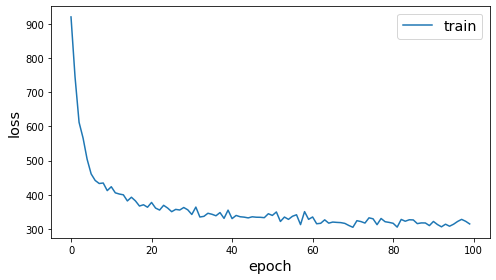

In [238]:
from stellargraph.utils import plot_history

plot_history(historyNN)

In [239]:
result = modelNN.evaluate(
    test_x,
    test_y, verbose=0)

In [240]:
result

332.7187194824219

In [241]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(test_y, modelNN.predict(test_x)))

332.7187208606351


In [220]:
a_RMSE

282.0908619542276